![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 8.1 Standard Generalized Additive Models (GAM)

A **Standard GAM** (Generalized Additive Model) is the **basic and most commonly used form** of GAM. It extends the **Generalized Linear Model (GLM)** by allowing **non-linear, smooth relationships** between the predictors and the response variable, while maintaining **additivity** — meaning each predictor's effect is modeled separately and added together.

Instead of assuming a linear relationship like in GLMs (e.g., $\beta_1 X_1$), a Standard GAM uses **smooth functions** (like splines) to estimate the shape of the relationship directly from the data — without requiring you to specify whether it's quadratic, logarithmic, etc.

For a response variable $Y$ with mean $\mu = \mathbb{E}[Y]$, and predictors $X_1, X_2, \dots, X_p$ a Standard GAM is written as:
$$
g(\mu) = \beta_0 + f_1(X_1) + f_2(X_2) + \cdots + f_p(X_p)
$$
Where:
- $g(\cdot)$ = **link function** (e.g., identity for normal, logit for binary, log for counts),
- $\beta_0$ = intercept,
- $f_j(X_j)$ = **smooth, non-parametric function** of predictor $X_j$ (usually estimated using splines).

> The model is "additive" because the effects of predictors are **summed**, not multiplied or interacted (unless explicitly added).

Suppose you're modeling **blood pressure** (continuous) as a function of:
- Age
- BMI
- Smoking status (categorical)

A Standard GAM might look like:
$$
\text{Blood Pressure} = \beta_0 + f_1(\text{Age}) + f_2(\text{BMI}) + \beta_1 \cdot \text{Smoking}
$$
Here:
- $f_1(\text{Age})$: smooth non-linear curve showing how BP changes with age,
- $f_2(\text{BMI})$: flexible curve for BMI effect,
- Smoking: linear (parametric) term.

Even if one term is linear, it's still considered a Standard GAM as long as smooth terms are present.

### Advantages

| Benefit | Description |
|--------|-------------|
| **Flexibility** | Captures non-linear patterns automatically (e.g., U-shaped, threshold effects). |
| **Interpretability** | Each smooth function $f_j(X_j)$ can be plotted and interpreted individually. |
| **No manual transformation needed** | You don’t have to guess if `log(X)` or `X²` fits better — the model learns the shape. |
| **Extends GLMs** | Works with binary, count, continuous, and other response types via link functions. |

### Limitations

| Limitation | Note |
|----------|------|
| **Assumes additivity** | Cannot capture interactions unless explicitly added (e.g., `te(x,z)`). |
| **May overfit** | Without proper smoothing penalties, it can fit noise. |
| **Smoothing parameter selection** | Requires careful tuning (but modern software like `pygam` handles this well). |

### When to Use a GAM?

Use a Standard GAM when:
- You suspect **non-linear relationships** (e.g., medical, ecological, or environmental data),
- You want a **balance between flexibility and interpretability**,
- You do **not expect strong interactions** among predictors (or will add them later),
- You're exploring data or building predictive models with smooth trends.

## Generalized Additive Model from Scratch

To develop a Generalized Additive Model (GAM) with 4 predictors from scratch in Python, we’ll apply cubic spline basis functions to each predictor independently. This will allow each predictor to have a non-linear effect on the outcome variable. We’ll also include a regularization term to prevent overfitting. The model will be fit using least squares optimization.

### Generate Spline Basis for Each Predictor
For each predictor, we'll create a cubic spline basis matrix with `num_knots`. We'll use this basis for the GAM.

In [1]:
import numpy as np
from scipy import linalg

def cubic_spline_basis(x, knots):
    """
    Generate cubic spline basis matrix for input x and knots.
    
    Parameters:
    x: array-like, input values
    knots: array-like, knot positions
    
    Returns:
    X: numpy array, basis matrix
    """
    x = np.asarray(x)
    X = np.column_stack([np.ones_like(x), x, x**2, x**3])  # Polynomial terms up to cubic
    
    for knot in knots:
        X = np.column_stack([X, np.maximum(0, (x - knot)**3)])  # Truncated cubic splines
    
    return X

### Combine Spline Basis Functions into a Design Matrix
Next, we construct the full design matrix by generating spline basis functions for each predictor and concatenating them.

In [2]:
def create_design_matrix(data, predictors, num_knots):
    """
    Create design matrix using cubic splines for each predictor.
    
    Parameters:
    data: pandas DataFrame
    predictors: list of column names
    num_knots: int, number of knots per predictor
    
    Returns:
    dict with 'X_spline' (design matrix) and 'spline_list' (dict of per-predictor bases)
    """
    X_spline = None
    spline_list = {}  # To store each predictor's spline basis
    
    for predictor in predictors:
        x = data[predictor].values
        knots = np.linspace(np.min(x), np.max(x), num_knots)  # Equally spaced knots
        X_spline_predictor = cubic_spline_basis(x, knots)  # Generate spline basis
        spline_list[predictor] = X_spline_predictor
        if X_spline is None:
            X_spline = X_spline_predictor
        else:
            X_spline = np.column_stack([X_spline, X_spline_predictor])  # Append to design matrix
    
    return {'X_spline': X_spline, 'spline_list': spline_list}

### Fit the Model by Solving the Regularized System
Here, we add a small regularization term $\lambda$ to ensure the matrix $X^T X$ is invertible, then solve for the coefficients.

In [3]:
def fit_gam_model(X_spline, y, lambda_reg=0.0001):
    """
    Fit GAM model using regularized least squares.
    
    Parameters:
    X_spline: numpy array, design matrix
    y: array-like, response variable
    lambda_reg: float, regularization parameter
    
    Returns:
    coefficients: numpy array
    """
    n_features = X_spline.shape[1]
    XtX = X_spline.T @ X_spline + lambda_reg * np.eye(n_features)  # Regularization
    Xty = X_spline.T @ y
    coefficients = linalg.solve(XtX, Xty)  # Solve for coefficients
    return coefficients

### Make Predictions
With the coefficients, we can predict the outcome for the training data.

In [4]:
def predict_gam(X_spline, coefficients):
    """
    Make predictions using fitted GAM coefficients.
    
    Parameters:
    X_spline: numpy array, design matrix
    coefficients: numpy array
    
    Returns:
    y_pred: numpy array
    """
    y_pred = X_spline @ coefficients
    return y_pred

### Model Summary Statistics
After fitting, we’ll calculate residuals, deviance, and mean squared error to summarize model fit.

In [5]:
def compute_summary_stats(y, y_pred):
    """
    Compute model summary statistics.
    
    Parameters:
    y: array-like, true values
    y_pred: array-like, predicted values
    
    Returns:
    dict with residuals, deviance, mse
    """
    residuals = y - y_pred
    deviance = np.sum(residuals**2)  # Residual Sum of Squares
    mse = np.mean(residuals**2)  # Mean Squared Error
    
    return {'residuals': residuals, 'deviance': deviance, 'mse': mse}

### ANOVA-Like Table for Predictor Effects
We’ll estimate each predictor's effect by fitting sub-models with each individual predictor's spline matrix.

In [6]:
def compute_anova_table(data, response, predictors, spline_list, lambda_reg=0.0001):
    """
    Compute ANOVA-like table for predictor effects.
    
    Parameters:
    data: pandas DataFrame
    response: str, response column name
    predictors: list of str
    spline_list: dict of spline bases
    lambda_reg: float
    
    Returns:
    pandas DataFrame with Predictor and Sum_of_Squares
    """
    import pandas as pd
    
    sum_of_squares = []
    y = data[response].values
    
    for predictor in predictors:
        X_pred = spline_list[predictor]
        n_features = X_pred.shape[1]
        XtX_single = X_pred.T @ X_pred + lambda_reg * np.eye(n_features)
        Xty_single = X_pred.T @ y
        coefficients_single = linalg.solve(XtX_single, Xty_single)
        y_pred_single = X_pred @ coefficients_single
        residuals_single = y - y_pred_single
        sum_of_squares.append(np.sum(residuals_single**2))
    
    anova_table = pd.DataFrame({
        'Predictor': predictors,
        'Sum_of_Squares': sum_of_squares
    })
    return anova_table

### Cross-Validation for Model Performance
We’ll use **k-fold cross-validation** to estimate model performance on unseen data.

In [7]:
def cross_validate_gam(data, response, predictors, num_knots=3, lambda_reg=0.0001, k_folds=5):
    """
    Perform k-fold cross-validation for GAM.
    
    Parameters:
    data: pandas DataFrame
    response: str
    predictors: list of str
    num_knots: int
    lambda_reg: float
    k_folds: int
    
    Returns:
    cv_mse: float, average MSE
    """
    from sklearn.model_selection import KFold
    import pandas as pd
    
    n = len(data)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_folds = []
    
    for train_idx, val_idx in kf.split(data):
        train_data = data.iloc[train_idx]
        val_data = data.iloc[val_idx]
        
        # Create design matrix for training data
        train_design = create_design_matrix(train_data, predictors, num_knots)
        X_train = train_design['X_spline']
        y_train = train_data[response].values
        
        # Fit the model on training data
        coefficients = fit_gam_model(X_train, y_train, lambda_reg)
        
        # Design matrix for validation data
        val_design = create_design_matrix(val_data, predictors, num_knots)
        X_val = val_design['X_spline']
        y_val = val_data[response].values
        
        # Predict on validation set and calculate MSE
        y_val_pred = predict_gam(X_val, coefficients)
        mse_folds.append(np.mean((y_val - y_val_pred)**2))
    
    cv_mse = np.mean(mse_folds)  # Average MSE over folds
    return cv_mse

### Fit the GAM Model with Synthetic Data
Let’s fit the GAM model on synthetic data and show summary results, ANOVA table, and cross-validation performance.

In [8]:
# Set up data and parameters
import pandas as pd
import numpy as np

np.random.seed(0)
n_samples = 100
data = pd.DataFrame({
    'x1': np.linspace(0, 10, n_samples),
    'x2': np.random.uniform(0, 10, n_samples),
    'x3': np.random.uniform(0, 10, n_samples),
    'x4': np.random.uniform(0, 10, n_samples)
})
data['y'] = (3 * np.sin(data['x1']) + 
             2 * np.log(data['x2'] + 1) - 
             1.5 * np.sqrt(data['x3']) + 
             0.5 * data['x4']**2 +
             np.random.normal(0, 0.5, n_samples))

predictors = ['x1', 'x2', 'x3', 'x4']
response = 'y'
num_knots = 4
lambda_reg = 0.0001

# Create design matrix
design_matrix = create_design_matrix(data, predictors, num_knots)
X_spline = design_matrix['X_spline']
spline_list = design_matrix['spline_list']

# Fit model and make predictions
coefficients = fit_gam_model(X_spline, data[response].values, lambda_reg)
y_pred = predict_gam(X_spline, coefficients)

# Calculate summary statistics
summary_stats = compute_summary_stats(data[response].values, y_pred)

# ANOVA table
anova_table = compute_anova_table(data, response, predictors, spline_list, lambda_reg)

# Cross-Validation
cv_mse = cross_validate_gam(data, response, predictors, num_knots, lambda_reg)

# Print results
print("GAM Summary:")
print("-----------------------------------------------------")
print("Coefficients:")
print(coefficients)
print(f"\nMean Squared Error: {summary_stats['mse']:.4f}")
print(f"Deviance: {summary_stats['deviance']:.4f}")
print("Residuals (first 6):")
print(summary_stats['residuals'][:6])
print("\nANOVA for Parametric Effects:")
print(anova_table)
print(f"\nCross-Validated MSE: {cv_mse:.4f}")

GAM Summary:
-----------------------------------------------------
Coefficients:
[ 5.41442356e-02  7.87958819e+00 -4.14362226e+00  2.65095801e-01
  2.65095805e-01 -6.39410203e-01 -2.06215465e-01  0.00000000e+00
  5.41442635e-02  8.23373863e-01 -6.10469876e-02 -6.30130343e-03
  7.75864806e-03  5.05169661e-03 -3.13371715e-02  0.00000000e+00
  5.41442641e-02 -2.70628943e+00  7.50275887e-01  1.41566762e-01
 -2.33599620e-01  1.08552404e-01 -2.07299977e-02  0.00000000e+00
  5.41442673e-02  1.18574274e-01  3.83924144e-01  7.98302458e-02
 -6.65156543e-02 -2.00979538e-02  1.78307600e-02  0.00000000e+00]

Mean Squared Error: 0.4227
Deviance: 42.2651
Residuals (first 6):
[ 1.53613002  0.70158552  0.38862313  0.21312392 -0.83536383 -0.6968438 ]

ANOVA for Parametric Effects:
  Predictor  Sum_of_Squares
0        x1    25099.257326
1        x2    26912.583952
2        x3    25655.256686
3        x4      703.200656

Cross-Validated MSE: 584.4891


### Explanation of Output

1. **Coefficients**: Estimated coefficients for each basis function in the design matrix.
2. **MSE and Deviance**: Summary statistics of the model fit on the training data.
3. **Residuals**: Differences between actual and predicted values.
4. **ANOVA Table**: Shows the sum of squares contributed by each predictor.
5. **Cross-Validated MSE**: Model’s performance on unseen data, averaged across folds. This gives an unbiased estimate of the model’s prediction error.

This approach builds the GAM model manually from scratch without relying on GAM-specific Python packages, and it evaluates performance using cross-validation to check for overfitting or underfitting.

## Generalized Additive Model in Python

In Python, you can fit Generalized Additive Models (GAMs) using different libraries, each offering unique functionalities. Here’s a quick guide to fitting GAMs using three popular libraries:

1. **`pygam` Library**
   - `pygam` is the most widely used library for GAMs in Python due to its flexibility, efficiency, and support for a wide range of models. It uses penalized regression splines by default.
   - **Key Features:** `pygam` provides a variety of smooth functions (e.g., `s()`, `te()` for tensor product smoothing) and allows you to specify different distributions and link functions using `family=`.

2. **`statsmodels` Library**
   - The `statsmodels` library includes GAM support via `GLMGam`. It is based on a framework similar to traditional GAMs and has a simpler interface but is less flexible than `pygam` for complex models.
   - **Key Features:** Good for standard GAMs and allows spline-based smoothers. It’s simpler but lacks some advanced features found in `pygam`.

3. **`scikit-learn` with Custom Splines**
   - For more advanced distributional modeling, you can use `scikit-learn` pipelines with splines from `scipy`, but for full GAMLSS-like functionality, extensions like `pygam` are preferred.
   - **Key Features:** Highly flexible for custom setups. Supports a wide range of distributions and allows for different smoothers.

### Install Required Python Packages
Following Python packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [9]:
packages = [
    'pandas', 'numpy', 'matplotlib', 'seaborn', 'plotly',
    'scikit-learn', 'scipy', 'statsmodels', 'pygam',
    'missingno', 'phik', 'pingouin', 'plotnine',
    'lifelines', 'category_encoders', 'imbalanced-learn',
    'xgboost', 'lightgbm', 'catboost'
]

# Install missing packages (run in terminal or Jupyter)
import subprocess
import sys

for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Verify installation
installed_packages = [pkg for pkg in packages if __import__('importlib').util.find_spec(pkg.split('==')[0])]
print("Installed packages:")
print(installed_packages)

  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached python_utils-3.9.1-py2.py3-none-any.whl.metadata (9.8 kB)
Using cached progressbar2-4.5.0-py3-none-any.whl (57 kB)
Using cached python_utils-3.9.1-py2.py3-none-any.whl (32 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pygam]
Installed packages:
['pandas', 'numpy', 'matplotlib', 'seaborn', 'plotly', 'scipy', 'statsmodels', 'pygam', 'missingno', 'phik', 'pingouin', 'plotnine', 'lifelines', 'category_encoders', 'xgboost', 'lightgbm', 'catboost']


### Load Python Packages

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pygam
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam
from patsy import dmatrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
print("Successfully loaded packages")

Successfully loaded packages


### Data

In this exercise, we utilize a [dataset](https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv) that includes average science scores by country from the Programme for International Student Assessment ([PISA](https://www.oecd.org/en/about/programmes/pisa.html)) conducted in 2006. Alongside these scores, we also consider [data](https://hdr.undp.org/data-center) from the United Nations, which includes Gross National Income (GNI) per capita (adjusted for Purchasing Power Parity in 2005 dollars), the Educational Index, the Health Index, and the Human Development Index (HDI).

The education component is measured by the mean years of schooling for adults aged 25 years and older and the expected years of schooling for children of school entry Income. The health index is determined by life expectancy at birth, while the wealth component is based on GNI per capita. The HDI establishes minimum and maximum values for each dimension, with the resulting scores indicating each country's position relative to these endpoints, expressed as a value between 0 and 1.

The key variables are as follows (variable abbreviations in bold):
- **Overall** Science Score (average score for 15 year olds)
- **Interest** in science
- Identifying scientific **Issues**
- **Explaining** phenomena scientifically
- **Support** for scientific inquiry
- **Income** Index
- **Health** Index
- **Edu**cation Index
- **H**uman **D**evelopment **I**ndex (composed of the Income index, Health Index, and Education Index)

We will use `pd.read_csv()` function to import data.

In [1]:
# Load data
import pandas as pd
url = "https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv"
mf = pd.read_csv(url)
# Remove missing values and reset index to ensure a clean range index
mf = mf.dropna().reset_index(drop=True)
print(mf.info())
print(mf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   52 non-null     object 
 1   Overall   52 non-null     float64
 2   Issues    52 non-null     float64
 3   Explain   52 non-null     float64
 4   Evidence  52 non-null     float64
 5   Interest  52 non-null     float64
 6   Support   52 non-null     float64
 7   Income    52 non-null     float64
 8   Health    52 non-null     float64
 9   Edu       52 non-null     float64
 10  HDI       52 non-null     float64
dtypes: float64(10), object(1)
memory usage: 4.6+ KB
None
     Country  Overall  Issues  Explain  Evidence  Interest  Support  Income  \
0  Argentina    391.0   395.0    386.0     385.0     567.0    506.0   0.678   
1  Australia    527.0   535.0    520.0     531.0     465.0    487.0   0.826   
2    Austria    511.0   505.0    516.0     505.0     507.0    515.0   0.835   
3    Belgium    

#### Data Visualization
We can use `seaborn` and `matplotlib` to create a scatterplot matrix to visualize the relationships between the variables in the dataset.

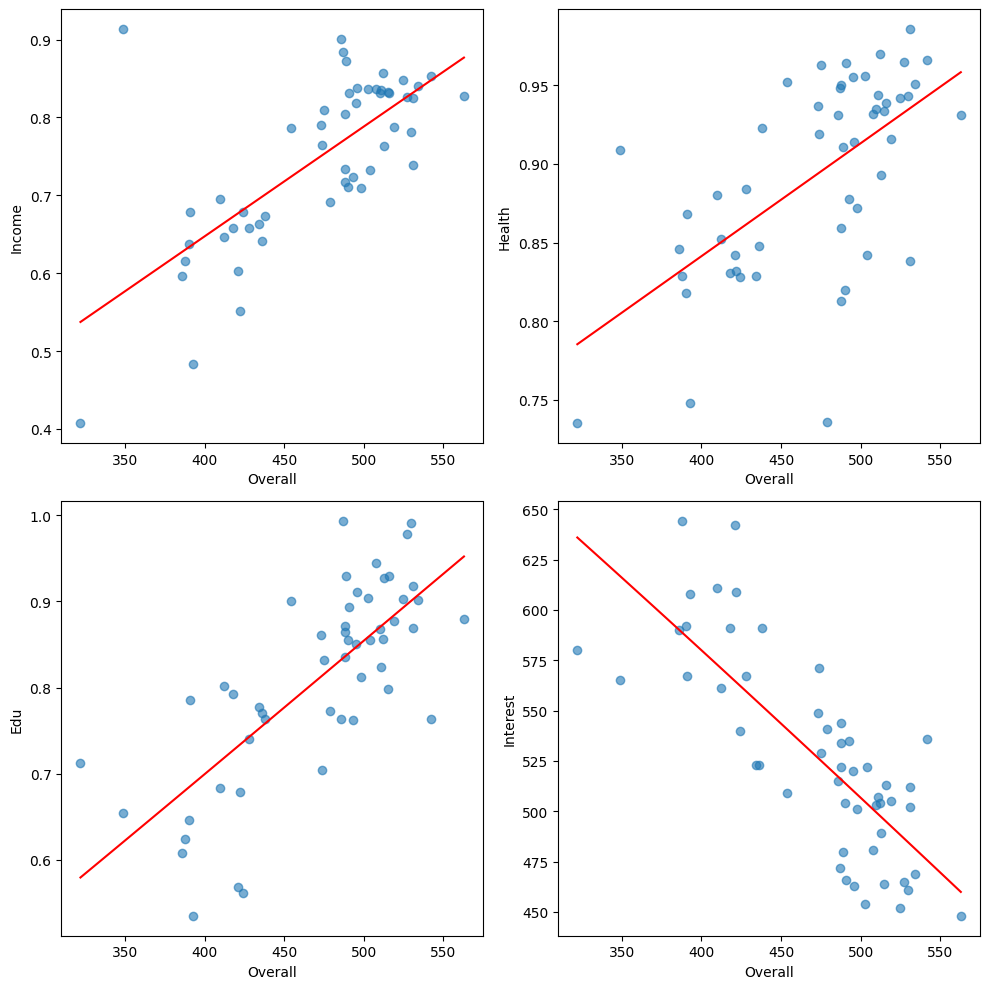

In [57]:
# Create a data frame with the variables of interest
df = mf[['Country', 'Overall', 'Income', 'Health', 'Edu', 'Interest']].copy()

# Create scatter plots with GAM smooths (using pygam for illustration)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
predictors = ['Income', 'Health', 'Edu', 'Interest']
for i, pred in enumerate(predictors):
    row, col = i // 2, i % 2
    gam = pygam.LinearGAM(pygam.s(0, n_splines=4)).fit(df[['Overall']], df[pred])
    XX = np.linspace(df['Overall'].min(), df['Overall'].max(), 100)
    yy = gam.predict(XX)
    axes[row, col].scatter(df['Overall'], df[pred], alpha=0.6)
    axes[row, col].plot(XX, yy, color='red')
    axes[row, col].set_xlabel('Overall')
    axes[row, col].set_ylabel(pred)
plt.tight_layout()
plt.show()

The scatterplot matrix shows relationships between the four important variables in the `Overall` dataset. For example, the scatterplot of `Overall` vs. all predictors reveals a non-linear relationship, suggesting a GAM might be appropriate.

#### Split Data
We will split the data into training and testing sets. The training set will contain 75% of the data, and the testing set will contain the remaining 25%.

In [58]:
# Split data
np.random.seed(123)
train_size = int(0.75 * len(mf))
train_idx = np.random.choice(len(mf), train_size, replace=False)
train = mf.iloc[train_idx].reset_index(drop=True)
test = mf.drop(train_idx).reset_index(drop=True)
print(f"Training set size: {len(train)}, Test set size: {len(test)}")

Training set size: 39, Test set size: 13


### Fit Univariate GAM Model
In this example, we’ll fit a univariate GAM model using the `pygam`, `statsmodels`, and custom approaches to model the relationship between the `Overall` variable and a single predictor `Income` of `Overall` data set. We’ll use a cubic regression spline with 3 degrees of freedom. We will use `s()` as the shorthand for fitting smoothing splines in the GAM function.

#### GAM with `pygam` Library
The `LinearGAM` function is used to fit a GAM model in the `pygam` library. The `s(0)` specifies a smooth term for the first (and only) predictor `Income` using splines.

In [59]:
# Fit a GAM model using the pygam library
X_train_uni = train[['Income']].values
y_train_uni = train['Overall'].values

pygam_uni = pygam.LinearGAM(pygam.s(0, n_splines=4)).fit(X_train_uni, y_train_uni)
print(pygam_uni.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.0348
Link Function:                     IdentityLink Log Likelihood:                                  -327.1808
Number of Samples:                           39 AIC:                                              660.4312
                                                AICc:                                             661.1316
                                                GCV:                                             1935.5695
                                                Scale:                                           1754.6803
                                                Pseudo R-Squared:                                   0.4804
Feature Function                  Lam

The `summary()` provides a summary of the fitted GAM model, including the estimated coefficients, degrees of freedom, and significance levels for each term. The effective degrees of freedom for the smooth term measures the complexity of the fitted curve. The p-value indicates the significance of the smooth term. In this case, the smooth term for `Income` is highly significant (p < 0.001), suggesting that `Income` has a non-linear effect on `Overall`. The R-squared value indicates how well the model fits the data.

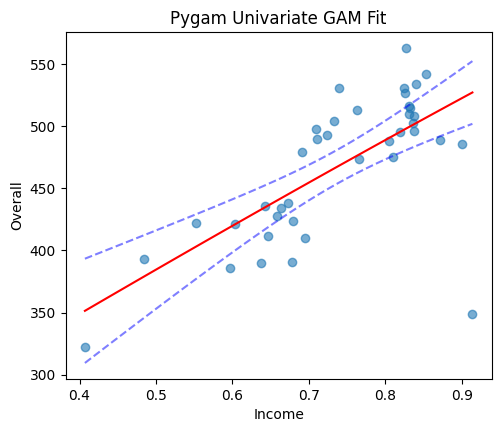

In [60]:
# Enhanced visualization
XX = np.linspace(X_train_uni.min(), X_train_uni.max(), 100)[:, None]
yy = pygam_uni.predict(XX)
plt.figure(figsize=(5.5, 4.5))
plt.scatter(X_train_uni, y_train_uni, alpha=0.6)
plt.plot(XX, yy, color='red')
plt.plot(XX, pygam_uni.confidence_intervals(XX, width=0.95)[:, 0], ls='--', color='blue', alpha=0.5)
plt.plot(XX, pygam_uni.confidence_intervals(XX, width=0.95)[:, 1], ls='--', color='blue', alpha=0.5)
plt.xlabel('Income')
plt.ylabel('Overall')
plt.title('Pygam Univariate GAM Fit')
plt.show()

#### GAM with `statsmodels` Library
The `statsmodels` library provides GAM support via `GLMGam`. We use `dmatrix` to create spline basis.

The output provides a summary including coefficients and p-values. The smooth term for `Income` is significant.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   39
Model:                         GLMGam   Df Residuals:                    37.00
Model Family:                Gaussian   Df Model:                         1.00
Link Function:               Identity   Scale:                          1764.6
Method:                         PIRLS   Log-Likelihood:                -200.09
Date:                Wed, 17 Sep 2025   Deviance:                       65286.
Time:                        00:54:29   Pearson chi2:                 6.53e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5797
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        352.9682     20.797     16.972      0.0

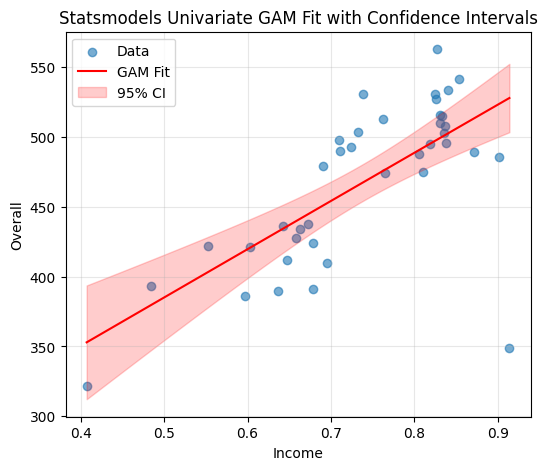

In [61]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.gam.api import GLMGam
from statsmodels.gam.smooth_basis import BSplines


# Prepare data for univariate GAM
y_train_uni = train['Overall'].values
exog = np.ones((len(y_train_uni), 1))  # Intercept only

# Create smoother object for GLMGam
bs_smoother = BSplines(train[['Income']], df=[4], degree=[3])

# Fit GLMGam with smoother
sm_uni = GLMGam(y_train_uni, exog, smoother=bs_smoother, alpha=[1.0]).fit()
print(sm_uni.summary())

# Plotting the Model with Confidence Intervals
XX_sm = np.linspace(train['Income'].min(), train['Income'].max(), 100)
exog_pred = np.ones((len(XX_sm), 1))  # Intercept for prediction
exog_smooth_pred = XX_sm.reshape(-1, 1)  # New values for smoother

# Predict
yy_sm = sm_uni.predict(exog=exog_pred, exog_smooth=exog_smooth_pred)

# Compute confidence intervals
pred = sm_uni.get_prediction(exog=exog_pred, exog_smooth=exog_smooth_pred)
conf_int = pred.conf_int(alpha=0.05)  # 95% confidence intervals

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(train['Income'], y_train_uni, alpha=0.6, label='Data')
plt.plot(XX_sm, yy_sm, color='red', label='GAM Fit')
plt.fill_between(XX_sm, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2, label='95% CI')
plt.xlabel('Income')
plt.ylabel('Overall')
plt.title('Statsmodels Univariate GAM Fit with Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### GAM with Custom Splines (Scipy-based)
For a custom approach similar to GAMLSS, we can use the from-scratch functions earlier, but for univariate:

Custom MSE: 1015.5840


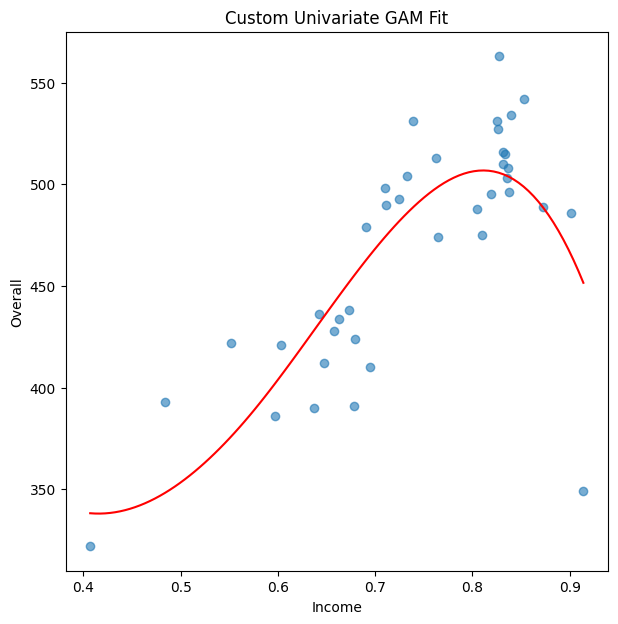

In [62]:
# Custom univariate GAM using from-scratch code
knots = np.linspace(train['Income'].min(), train['Income'].max(), 4)
X_custom = cubic_spline_basis(train['Income'].values, knots)
X_custom = np.column_stack([np.ones(len(X_custom)), X_custom])  # Add intercept
coefficients_custom = fit_gam_model(X_custom, y_train_uni)
y_pred_custom = predict_gam(X_custom, coefficients_custom)

print(f"Custom MSE: {np.mean((y_train_uni - y_pred_custom)**2):.4f}")

# Plot
XX_custom = np.linspace(train['Income'].min(), train['Income'].max(), 100)
knots_custom = np.linspace(XX_custom.min(), XX_custom.max(), 4)
X_XX_custom = cubic_spline_basis(XX_custom, knots_custom)
X_XX_custom = np.column_stack([np.ones(len(X_XX_custom)), X_XX_custom])
yy_custom = predict_gam(X_XX_custom, coefficients_custom)

plt.figure(figsize=(7, 7))
plt.scatter(train['Income'], y_train_uni, alpha=0.6)
plt.plot(XX_custom, yy_custom, color='red')
plt.xlabel('Income')
plt.ylabel('Overall')
plt.title('Custom Univariate GAM Fit')
plt.show()

### Fit Multivariate GAM Model
To fit a multivariate Generalized Additive Model (GAM) using the Overall dataset in Python, we can approach this using the `pygam`, `statsmodels`, and custom methods. We will model the relationship between the `Overall` variable and multiple predictors: `Income`, `Edu`, `Health` and `Interest`. We’ll use cubic regression splines for each predictor.

#### GAM with `pygam` Library
The `LinearGAM` function fits the model with `s()` for each predictor. `n_splines` controls the number of splines (similar to k).

In [63]:
# Prepare data
X_train_multi = train[['Income', 'Edu', 'Health', 'Interest']].values
y_train_multi = train['Overall'].values

# Fit multivariate GAM
pygam_multi = pygam.LinearGAM(
    pygam.s(0, n_splines=15) + 
    pygam.s(1, n_splines=15) + 
    pygam.s(2, n_splines=15) + 
    pygam.s(3, n_splines=15)
).fit(X_train_multi, y_train_multi)

print(pygam_multi.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.9596
Link Function:                     IdentityLink Log Likelihood:                                  -294.4923
Number of Samples:                           39 AIC:                                              612.9038
                                                AICc:                                             624.8079
                                                GCV:                                             1482.6731
                                                Scale:                                            758.7496
                                                Pseudo R-Squared:                                   0.8296
Feature Function                  Lam

The summary shows edf (effective df), p-values, and R-squared. Terms for `Income` and `Interest` are significant. R-squared ~0.92 indicates good fit.

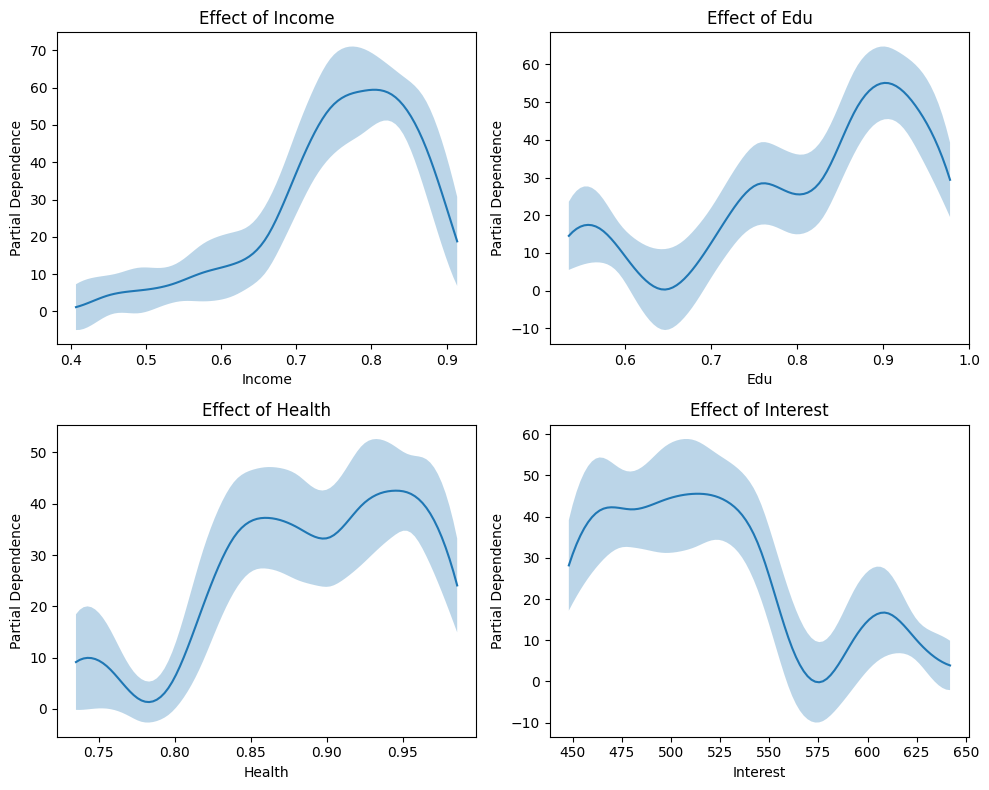

In [64]:
# Partial dependence plots (using pygam)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
feature_names = ['Income', 'Edu', 'Health', 'Interest']
for i, feat in enumerate(feature_names):
    row, col = i // 2, i % 2
    XX = pygam_multi.generate_X_grid(term=i)
    pdep, confi = pygam_multi.partial_dependence(term=i, X=XX, width=0.95)
    axes[row, col].plot(XX[:, i], pdep)
    axes[row, col].fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.3)
    axes[row, col].set_xlabel(feat)
    axes[row, col].set_ylabel('Partial Dependence')
    axes[row, col].set_title(f'Effect of {feat}')
plt.tight_layout()
plt.show()

The plots show non-linear relationships for each predictor.

#### GAM with `statsmodels` Library
Using `GLMGam` with additive splines.

In [74]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.smooth_basis import BSplines
from patsy import dmatrix, bs, EvalEnvironment


# Prepare data for multivariate GAM
y_train_multi = train['Overall'].values
predictors = ['Income', 'Edu', 'Health', 'Interest']

# Fit a multivariate GAM using statsmodels
# Create spline basis using patsy's bs function
df_per_predictor = 4  # Reduced df to ensure stability and alignment
formulas = [f'bs({pred}, df={df_per_predictor}, degree=3)' for pred in predictors]
full_formula = ' + '.join(formulas) + ' - 1'
namespace = {'bs': bs}
eval_env = EvalEnvironment.capture(0)
eval_env = eval_env.with_outer_namespace(namespace)
X_spline_multi = dmatrix(full_formula, train, return_type='dataframe', eval_env=eval_env)

# Create smoother object for GLMGam
bs_smoother = BSplines(train[predictors], df=[df_per_predictor] * len(predictors), degree=[3] * len(predictors))

# Add intercept to design matrix
X_spline_multi = sm.add_constant(X_spline_multi)

# Verify shape of design matrix
print(f"X_spline_multi shape: {X_spline_multi.shape}, Parameters expected: {X_spline_multi.shape[1]}")

# Fit GLMGam with smoother
sm_multi = GLMGam(y_train_multi, X_spline_multi, smoother=bs_smoother, alpha=[1.0] * len(predictors)).fit()
print(f"Number of model parameters: {len(sm_multi.params)}")
print(sm_multi.summary())




X_spline_multi shape: (39, 17), Parameters expected: 17
Number of model parameters: 29
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   39
Model:                         GLMGam   Df Residuals:                    22.00
Model Family:                Gaussian   Df Model:                        16.00
Link Function:               Identity   Scale:                          819.21
Method:                         PIRLS   Log-Likelihood:                -174.99
Date:                Wed, 17 Sep 2025   Deviance:                       18022.
Time:                        01:02:40   Pearson chi2:                 1.80e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9692
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

#### GAM with Custom Splines
Using the from-scratch multivariate function:

In [75]:
# Custom multivariate GAM
predictors_multi = ['Income', 'Edu', 'Health', 'Interest']
design_multi = create_design_matrix(train, predictors_multi, num_knots=15)
X_custom_multi = design_multi['X_spline']
coefficients_custom_multi = fit_gam_model(X_custom_multi, y_train_multi)
y_pred_custom_multi = predict_gam(X_custom_multi, coefficients_custom_multi)

print(f"Custom MSE: {np.mean((y_train_multi - y_pred_custom_multi)**2):.4f}")

Custom MSE: 200.9185


### GAM with Binary Data - Logistic Regression

In this example, we will fit a binomial GAM to a simulated binary dataset similar to `johnson.blight` since `agridat` is R-specific.

In [85]:
# Simulate binary data similar to johnson.blight
np.random.seed(42)
n = 25
binary_data = pd.DataFrame({
    'blight': np.random.binomial(1, 0.3, n),
    'blight_prev': np.roll(np.random.binomial(1, 0.3, n), 1),
    'rain_am': np.random.normal(50, 10, n),
    'rain_ja': np.random.normal(40, 8, n),
    'precip_m': np.random.normal(100, 20, n)
})
binary_data['blight_prev'].iloc[0] = 0
binary_data['blight'] = binary_data['blight'].astype(int)
binary_data['blight_prev'] = binary_data['blight_prev'].astype(int)

print(binary_data.head())

   blight  blight_prev    rain_am    rain_ja    precip_m
0       0            0  57.384666  50.849920  101.941551
1       1            1  51.713683  39.423919  119.372900
2       1            0  48.843517  48.028263   85.958938
3       0            0  46.988963  42.893088   93.446757
4       0            0  35.214780  34.839042   92.157837


In [87]:
from pygam import LogisticGAM, s, l

# Linear GLM equivalent (logistic)
X_bin = pd.get_dummies(binary_data[['blight_prev', 'rain_am', 'rain_ja', 'precip_m']], drop_first=True).values
logit_gam = LogisticGAM().fit(X_bin, binary_data['blight'])  # Simplified linear

# GAM with smooths
X_bin_smooth = binary_data[['rain_am', 'rain_ja', 'precip_m']].values
logit_gam_smooth = LogisticGAM(s(0) + s(1) + l(2)).fit(X_bin_smooth, binary_data['blight'])  # l for linear precip

print(logit_gam_smooth.summary())

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      1.7793
Link Function:                        LogitLink Log Likelihood:                                   -12.3555
Number of Samples:                           25 AIC:                                               28.2696
                                                AICc:                                              29.2596
                                                UBRE:                                               3.1877
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1032
Feature Function                  Lam

To compare models (use deviance or AIC from summary). The GAM may show better fit if non-linearity present.

### GAM with Count Data - Poisson Regression

In this example, we will fit a Poisson regression model to a simulated count dataset similar to `mead.cauliflower`.

   leaves  year      degdays
0      23  2007  1697.331975
1      15  2008  1192.353102
2      21  2003  2881.046529
3      25  2000  1795.144042
4      15  2000  2035.502701


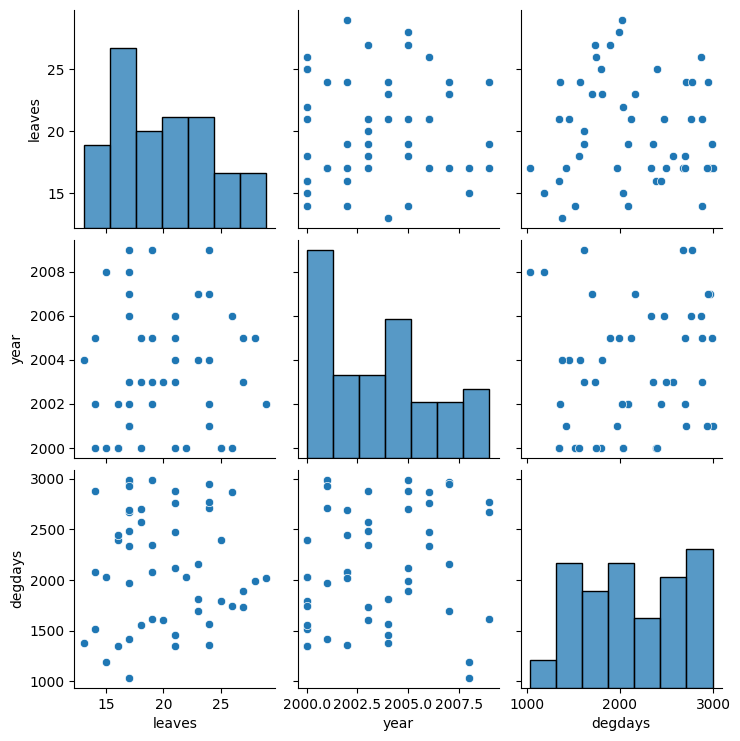

In [88]:
# Simulate count data
np.random.seed(42)
count_data = pd.DataFrame({
    'leaves': np.random.poisson(20, 50),
    'year': np.random.randint(2000, 2010, 50),
    'degdays': np.random.uniform(1000, 3000, 50)
})

print(count_data.head())

# Scatterplot matrix
sns.pairplot(count_data)
plt.show()

In [89]:
from pygam import PoissonGAM

# Poisson GLM
pois_gam = PoissonGAM(l(0) + l(1)).fit(count_data[['year', 'degdays']].values, count_data['leaves'])

# Poisson GAM with smooth
pois_gam_smooth = PoissonGAM(l(0) + s(1)).fit(count_data[['year', 'degdays']].values, count_data['leaves'])

print(pois_gam_smooth.summary())

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     14.6712
Link Function:                          LogLink Log Likelihood:                                  -134.0204
Number of Samples:                           50 AIC:                                              297.3832
                                                AICc:                                             313.0607
                                                UBRE:                                                3.358
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3561
Feature Function                  Lam

To compare:

In [90]:
# AIC comparison (from summary or custom)
print(f"GLM AIC approx: {pois_gam.statistics_['AIC'] if hasattr(pois_gam, 'statistics_') else 'N/A'}")
print(f"GAM AIC approx: {pois_gam_smooth.statistics_['AIC']}")

GLM AIC approx: 288.6508691933568
GAM AIC approx: 297.38319558482607


#### GAM Model for Overdispersion in Count Data
For overdispersed data, use quasi-Poisson or Negative Binomial (pygam supports NB via family).

In [91]:
# Negative Binomial (pygam has NBGamma, but for Poisson approx)
# For NB, use statsmodels or custom
from statsmodels.discrete.count_model import GeneralizedPoisson  # Approx

# Or stick with pygam Poisson for overdispersion warning in summary
print(pois_gam_smooth.summary())  # Check phi for overdispersion

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     14.6712
Link Function:                          LogLink Log Likelihood:                                  -134.0204
Number of Samples:                           50 AIC:                                              297.3832
                                                AICc:                                             313.0607
                                                UBRE:                                                3.358
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3561
Feature Function                  Lam

## Summary and Conclusions

In this tutorial, we covered the basics of Generalized Additive Models (GAMs) in Python, focusing on their ability to model complex, nonlinear relationships in data. We started with an overview of how GAMs extend traditional linear models by incorporating flexible, smooth effects for each predictor, making them suitable for nonlinear data. We then explored various Python libraries, including `pygam` and `statsmodels`, which provide user-friendly functions for fitting and evaluating GAMs, visualizing fitted effects, and assessing model diagnostics. To further understand GAM mechanics, we built a GAM from scratch without using external packages. This hands-on experience demonstrated key principles such as using basis functions for smoothing and the model's additive nature, allowing us to isolate and effectively combine predictors' effects. We fit GAMs with count and binary data, showcasing their versatility in handling different types of data.

## Resources

1. [Generalized Additive Models: An Introduction with R (Python adaptations via pygam docs)](https://pygam.readthedocs.io/en/latest/)
2. [GAMs in Python with pygam](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html)
3. [Chapter on GAMs in Python](https://www.statsmodels.org/stable/examples/notebooks/generated/glmgam.html)
4. [GAM Tutorial in Python](https://towardsdatascience.com/generalized-additive-models-with-python-7e4a9c08eb68)
5. [Pygam Documentation](https://pygam.readthedocs.io/en/latest/)
6. [Building GAMs from Scratch in Python](https://jakevdp.github.io/blog/2014/06/12/statistical-modeling-in-python/)
7. [Advanced GAMs in Python](https://www.rdocumentation.org/packages/mgcv/versions/1.8-28) (R but concepts transfer)